In [1]:
import datetime as dt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tweepy
from matplotlib import style
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from textblob import TextBlob

In [2]:
consumer_key = 'pj6YNhZZBugJ2iVTzprRFeyVv'
consumer_secret = 'vV71WKQdcaMuhYIDKufIdSOAxwiydLGGskpj0bueAPeOKruwoT'
access_token = '1184086168608088064-863KtlQN4hww75kvv8J5OpAn0nNnzj'
access_token_secret = 'bdwBvlMmpLT2WYDBo9rQNMFtuldjduOoPXOHsi6rmehwT'

In [3]:
class Tweet(object):

    def __init__(self, content, polarity):
        self.content = content
        self.polarity = polarity

# Try To forcast stock with LR

In [4]:
def stock_forecasting(df):
    forecast_col = 'Close'
    forecast_out = int(math.ceil(0.1*len(df)))
    df['Label'] = df[[forecast_col]].shift(-forecast_out)

    X = np.array(df.drop(['Label'], axis=1))
    X = preprocessing.scale(X)
    X_forecast = X[-forecast_out:]
    X = X[:-forecast_out]

    df.dropna(inplace=True)
    y = np.array(df['Label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    forecast = clf.predict(X_forecast)

    df['Prediction'] = np.nan

    last_date = df.iloc[-1].name
    last_date = dt.datetime.strptime(str(last_date), "%Y-%m-%d %H:%M:%S")

    for pred in forecast:
        last_date += dt.timedelta(days=1)
        df.loc[last_date.strftime("%Y-%m-%d")] = [np.nan for _ in range(len(df.columns) - 1)] + [pred]
    return df, forecast_out

In [5]:
def forecast_plot(df):
    df['Close'].plot(color='black')
    df['Prediction'].plot(color='green')
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

In [6]:
def retrieving_tweets_polarity(symbol):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    user = tweepy.API(auth)
    num_of_tweets = 100

    tweets = tweepy.Cursor(user.search, q=str(symbol), tweet_mode='extended', lang='en').items(num_of_tweets)

    tweet_list = []
    global_polarity = 0
    for tweet in tweets:
        tw = tweet.full_text
        blob = TextBlob(tw)
        polarity = 0
        for sentence in blob.sentences:
            polarity += sentence.sentiment.polarity
            global_polarity += sentence.sentiment.polarity
        tweet_list.append(Tweet(tw, polarity))

    global_polarity = global_polarity / len(tweet_list)
    return global_polarity

In [7]:
def recommending(df, forecast_out, global_polarity):
    if df.iloc[-forecast_out-1]['Close'] < df.iloc[-1]['Prediction']:
        if global_polarity > 0:
            print("According to the predictions and twitter sentiment analysis -> Investing in %s is a GREAT idea!" % str(symbol))
        elif global_polarity < 0:
            print("According to the predictions and twitter sentiment analysis -> Investing in %s is a BAD idea!" % str(symbol))
    else:
        print("According to the predictions and twitter sentiment analysis -> Investing in %s is a BAD idea!" % str(symbol))


In [8]:
fb = pd.read_csv('fb.csv',index_col='Date',parse_dates=True)
fb.head()

,Open,High,Low,Close,Volume,Daily Change
Date,,,,,,
2019-01-02,128.99,137.51,128.56,135.68,28146192,0.000000
2019-01-03,134.69,137.17,131.12,131.74,22717948,-0.029039
2019-01-04,134.01,138.00,133.75,137.95,29002060,0.047138
2019-01-07,137.56,138.87,135.91,138.05,20089336,0.000725
2019-01-08,139.89,143.14,139.54,142.53,26263792,0.032452


In [9]:
(dataframe, forecast_out) = stock_forecasting(fb)

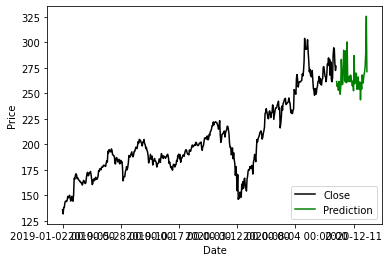

In [10]:
forecast_plot(dataframe)

In [11]:
symbol = '$fb'
polarity = retrieving_tweets_polarity(symbol)

In [12]:
recommending(dataframe, forecast_out, polarity)

According to the predictions and twitter sentiment analysis -> Investing in $fb is a BAD idea!
